In [5]:
import pandas as pd
import seaborn as sns
import torch

from src.coati.models.io import load_e3gnn_smiles_clip_e2e

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading model from s3://terray-public/models/grande_closed.pkl


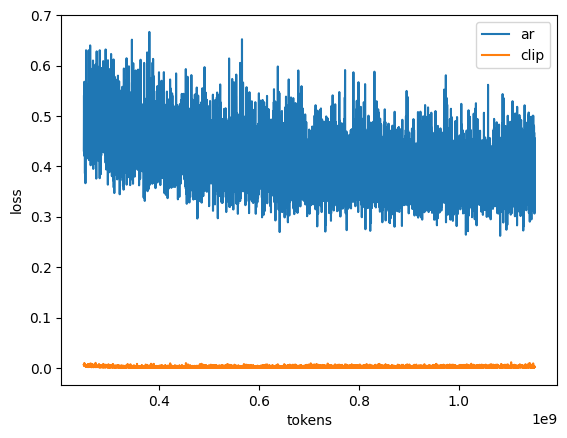

NTokens:  1152504376
Model kwargs:  {'n_layer_xformer': 16, 'n_layer_e3gnn': 5, 'n_hidden_e3nn': 256, 'n_hidden_xformer': 256, 'n_embd_common': 256, 'biases': True, 'n_head': 16, 'n_seq': 250, 'n_tok': 10322, 'torch_emb': False, 'norm_clips': True, 'norm_embed': False, 'token_mlp': True}
Loading tokenizer may_closedparen from s3://terray-public/models/grande_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file


In [50]:
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    # model parameters to load.
    doc_url="s3://terray-public/models/grande_closed.pkl",
    freeze=False,
    device=torch.device("cpu"),
    print_debug=True,
)

In [7]:
encoder

e3gnn_smiles_clip_e2e(
  (point_encoder): e3gnn_clip(
    (act_fn): SiLU()
    (embedding): Linear(in_features=28, out_features=256, bias=True)
    (embedding_norm): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (node_dec): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): SiLU()
      (2): Identity()
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (gcl_0): e_gcl_sparse(
      (instance_norm): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (edge_mlp): Sequential(
        (0): Linear(in_features=513, out_features=256, bias=True)
        (1): SiLU()
        (2): Identity()
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): SiLU()
        (5): Identity()
      )
      (node_mlp): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): SiLU()
        (2): Identity()
        (3):

In [51]:
smiles = [
    "CC1CC2=CCOC2O1",
    "OC1CC1(O)CC1CC1",
    "CC1N2C=NCC12C#C",
    "CC1COC11C(O)C1O",
    "CC12OCC(CO1)C2=O",
    "CC12CC(CO1)CC2=O",
    "CCN=COC",
    "CC1(CO)CO1",
    "C(C#N)C(=O)N",
    "CC(=O)OC=N",
]

In [61]:
batch_tokens = torch.tensor(
    [
        tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
        if s != "*"
        else tokenizer.tokenize_text("[SMILES]C[STOP]", pad=True)
        for s in smiles
    ],
    device="cpu",
    dtype=torch.int,
)

In [53]:
batch_tokens.shape

torch.Size([10, 250])

In [62]:
batch_embeds = encoder.encode_tokens(batch_tokens, tokenizer)

In [55]:
encoder.xformer

RotarySmilesTransformer(
  (norm_embed): Identity()
  (emb): RotaryEmbedding(
    (tok_emb): Embedding(10322, 256)
  )
  (transformer): ModuleDict(
    (h): ModuleList(
      (0-15): 16 x RotaryBlock(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): RotarySelfAttention(
          (c_attn): Linear(in_features=256, out_features=768, bias=True)
          (c_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlpf): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): NewGELU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=10322, bias=False)
)

In [56]:
encoder.to("cpu")

e3gnn_smiles_clip_e2e(
  (point_encoder): e3gnn_clip(
    (act_fn): SiLU()
    (embedding): Linear(in_features=28, out_features=256, bias=True)
    (embedding_norm): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (node_dec): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): SiLU()
      (2): Identity()
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (gcl_0): e_gcl_sparse(
      (instance_norm): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (edge_mlp): Sequential(
        (0): Linear(in_features=513, out_features=256, bias=True)
        (1): SiLU()
        (2): Identity()
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): SiLU()
        (5): Identity()
      )
      (node_mlp): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): SiLU()
        (2): Identity()
        (3):

In [57]:
encoder.batch_smiles_to_s2s_likelihood(smiles, tokenizer)

(tensor([ 5.1528,  3.8842, 41.5446,  4.8210,  7.4189,  2.2844,  2.4983,  0.7494,
         21.5638,  5.3194], grad_fn=<SumBackward1>),
 tensor([True, True, True, True, True, True, True, True, True, True]))

In [63]:
encoder.xformer.forward(batch_tokens)

tensor([[[ -4.7370,   0.3078,   1.6261,  ...,  -0.0516,  -3.1638,   0.5547],
         [-11.4987,  -0.3192,  -1.5464,  ...,  -6.1698, -10.2218,  -3.1609],
         [ -8.4435,   0.8021,  -0.8089,  ...,  -2.4167,  -7.5098,  -2.4759],
         ...,
         [-10.3736,   2.5105,  -0.7439,  ...,  -4.9863,  -8.6617,  -3.3883],
         [-10.2333,   2.5897,  -0.6997,  ...,  -4.8988,  -8.5454,  -3.3025],
         [-10.0865,   2.5194,  -0.6686,  ...,  -4.8681,  -8.4047,  -3.2709]],

        [[ -4.7370,   0.3078,   1.6261,  ...,  -0.0516,  -3.1638,   0.5547],
         [-11.6163,  -2.5803,  -1.9344,  ...,  -5.1848, -10.3400,  -5.3778],
         [ -9.6973,   3.3149,  -1.9919,  ...,  -2.9876,  -7.5202,  -5.2770],
         ...,
         [-10.5352,   4.5065,  -0.2985,  ...,  -4.9456,  -8.7423,  -3.3941],
         [-10.7862,   4.4251,  -0.2186,  ...,  -5.1446,  -8.9914,  -3.7423],
         [-10.8848,   4.3139,  -0.1930,  ...,  -5.3303,  -9.0748,  -3.8258]],

        [[ -4.7370,   0.3078,   1.6261,  ...

In [68]:
unfold_metrics = {
    "Average/F1": 0.2,
    "Average/Precision": 0.2,
    "Average/Recall": 0.4,
    "Average/Top1": 0.2,
    "BRAC1/F1": 0.1,
    "BRAC1/Precision": 0.1,
    "BRAC1/Recall": 0.2,
    "BRAC1/Top1": 0.1,
    "BRAC2/F1": 0.3,
    "BRAC2/Precision": 0.3,
    "BRAC2/Recall": 0.6,
    "BRAC2/Top1": 0.3,
}

In [82]:
series = pd.Series(unfold_metrics, name="value")

In [83]:
df = series.reset_index()
df["Gene"] = df["index"].str.split("/").str[0]
df["Metric"] = df["index"].str.split("/").str[1]

In [84]:
df

,index,value,Gene,Metric
0,Average/F1,0.2,Average,F1
1,Average/Precision,0.2,Average,Precision
2,Average/Recall,0.4,Average,Recall
3,Average/Top1,0.2,Average,Top1
4,BRAC1/F1,0.1,BRAC1,F1
5,BRAC1/Precision,0.1,BRAC1,Precision
6,BRAC1/Recall,0.2,BRAC1,Recall
7,BRAC1/Top1,0.1,BRAC1,Top1
8,BRAC2/F1,0.3,BRAC2,F1
9,BRAC2/Precision,0.3,BRAC2,Precision


<Axes: xlabel='Metric', ylabel='value'>

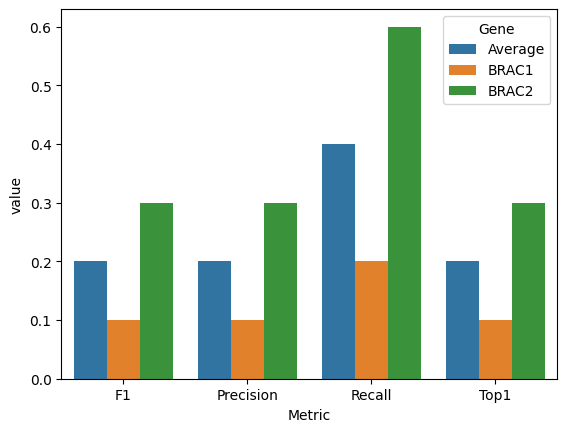

In [87]:
sns.barplot(data=df, x="Metric", y="value", hue="Gene")